In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import wandb
import os
import random

%matplotlib inline

In [2]:
def plot_graphs(log, tpe='loss'):
    keys = log.keys()
    logs = {k:[z for z in zip(*log[k])] for k in keys}
    epochs = {k:range(len(log[k])) for k in keys}
    
    if tpe == 'loss':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label=k)
                        for k in keys])
        plt.title('errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend(handles=handlers)
        plt.show()
        
    elif tpe == 'accuracy':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k)
                        for k in log.keys()])
        plt.title('accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(handles=handlers)
        plt.show()

In [3]:
class CFG:

# Задаем параметры нашего эксперимента

    api = 'fab999bcb2cc8902bcdf3d02affb15cd4519ab87'
    project = "gradient_vanishing"
    entity = "stureiko"
    num_epochs = 10
    train_batch_size = 64
    test_batch_size = 512
    num_workers = 4
    lr = 0.0001
    momentum = 0.9
    seed = 43
    classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
    wandb = True
    path = './MNIST_data'
    name = 'model_1'

In [4]:
# Зафиксируем seed для воспроизводимости

def seed_everything(seed):
    random.seed(seed) # фиксируем генератор случайных чисел
    os.environ['PYTHONHASHSEED'] = str(seed) # фиксируем заполнения хешей
    np.random.seed(seed) # фиксируем генератор случайных чисел numpy
    torch.manual_seed(seed) # фиксируем генератор случайных чисел pytorch
    torch.cuda.manual_seed(seed) # фиксируем генератор случайных чисел для GPU
    torch.backends.cudnn.deterministic = True # выбираем только детерминированные алгоритмы (для сверток)
    torch.backends.cudnn.benchmark = False # фиксируем алгоритм вычисления сверток

In [5]:
# Переведем наш класс с параметрами в словарь

def class2dict(f):
  return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

In [6]:
train_data = datasets.FashionMNIST(root=CFG.path, train=True, download=True,
                                    transform=transforms.Compose([
                                    transforms.ToTensor(),
                                ]))
train_loader = DataLoader(train_data, batch_size=CFG.train_batch_size, shuffle=False)

In [7]:
n_samples_seen = 0.
mean = 0
std = 0
for train_batch, train_target in train_loader:
    batch_size = train_batch.shape[0]
    train_batch = train_batch.view(batch_size, -1)
    this_mean = torch.mean(train_batch, dim=1)
    this_std = torch.sqrt(
        torch.mean((train_batch - this_mean[:, None]) ** 2, dim=1))
    mean += torch.sum(this_mean, dim=0)
    std += torch.sum(this_std, dim=0)
    n_samples_seen += batch_size

mean /= n_samples_seen
std /= n_samples_seen

print(f'mean = {mean}, std = {std}')

mean = 0.2860407531261444, std = 0.32024866342544556


In [8]:
mnist_fashion_transform = transforms.Compose([
    transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)
    ])

In [9]:
train_data = datasets.FashionMNIST(root=CFG.path, train=True,
                                    download=True, transform=mnist_fashion_transform)
test_data = datasets.FashionMNIST(root=CFG.path, train=False,
                                    download=True, transform=mnist_fashion_transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                            shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                            shuffle=False)

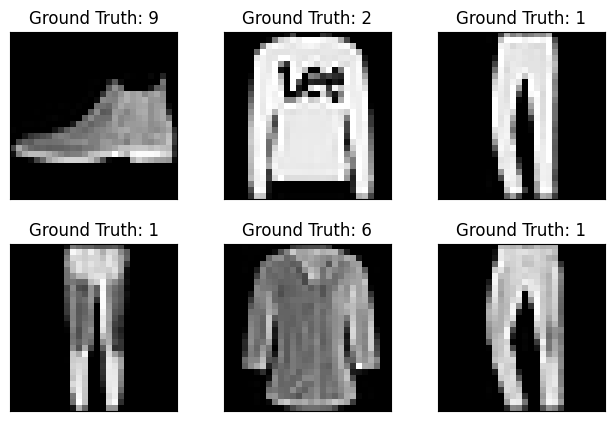

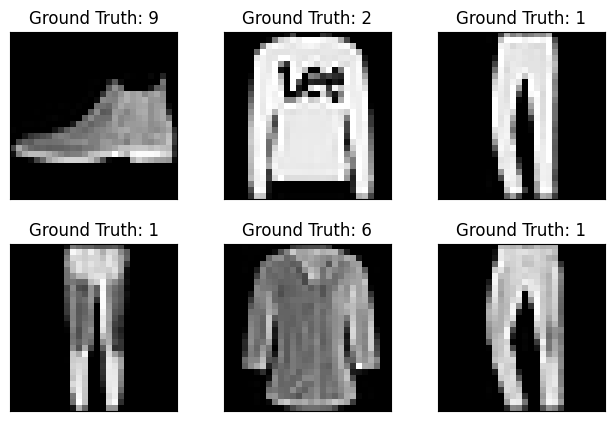

In [10]:
# Отрисуем пример изображений
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

In [11]:
# Определяем сеть

class Net(nn.Module):
    def __init__(self, hidden_1=256, hidden_2=128, constant_weight=None, normal=False, xavier_uniform=False, he_normal=False):
        super(Net, self).__init__()
        self.name = 'default'

        self.fc1 = nn.Linear(28 * 28, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, 10)
        self.dropout = nn.Dropout(0.2)
        self.bn = nn.BatchNorm1d(hidden_1)
        
        # Инициализируем по-разному веса

        if(constant_weight is not None):
            self.name = 'constant_' + str(constant_weight)
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.constant_(m.weight, constant_weight)
                    nn.init.constant_(m.bias, 0)
        
        if normal:
            self.name = 'normal'  # Нормальное распределение для весов и смещений модели.
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.normal_(m.weight)
                    nn.init.constant_(m.bias, 0)
        
        if xavier_uniform:
            self.name = 'xavier_uniform'  # Распределение Xavier для весов модели. Смещения равны 0.
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_uniform_(m.weight)
                    nn.init.constant_(m.bias, 0)
        
        if he_normal:
            self.name = 'he_normal'  # Распределение He для весов модели. Смещения равны 0.
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.kaiming_uniform_(m.weight)
                    nn.init.constant_(m.bias, 0)
    
            
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.bn(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [12]:
def train(model, device, train_loader, optimizer, criterion, epoch, WANDB):
    model.train()
    test_loss = 0
    correct = 0
    
    n_ex = len(train_loader)
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        train_loss = criterion(output, target)
        train_loss.backward()
        optimizer.step()

    # tqdm.write('\nTrain set: Average loss: {:.4f}, Accuracy: {:.0f}%'.format(
    #     train_loss, 100. * correct / len(train_loader.dataset)))
    
    if WANDB:
        wandb.log({'train_loss': train_loss,
                    'train_accuracy': correct / len(train_loader.dataset)})

In [13]:
def test(model, device, test_loader, criterion, WANDB):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss = criterion(output, target)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    # tqdm.write('Test set: Average loss: {:.4f}, Accuracy: {:.0f}%'.format(
    #     test_loss, 100. * correct / len(test_loader.dataset)))
    
    if WANDB:
        wandb.log({'test_loss': test_loss,
                    'test_accuracy': correct / len(test_loader.dataset)})

In [14]:
def main(model):
    
    if CFG.wandb:
        os.environ["WANDB_API_KEY"] = CFG.api
        wandb.init(project=CFG.project, 
                    entity=CFG.entity, 
                    reinit=True, 
                    config=class2dict(CFG), 
                    name = model.name + '_seed_' + str(CFG.seed))
    use_cuda = torch.cuda.is_available()

    seed_everything(CFG.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': CFG.num_workers, 'pin_memory': True} if use_cuda else {}

    model = model.to(device)
    
    
    if CFG.wandb:
        wandb.watch(model, log='all')
    
    optimizer = optim.SGD(model.parameters(),
                            lr=CFG.lr,
                            momentum=CFG.momentum)
    
    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, CFG.num_epochs + 1):
        print('\nEpoch:', epoch)
        train(model, device, train_loader, optimizer, criterion, epoch, CFG.wandb)
        test(model, device, test_loader, criterion, CFG.wandb)
    print('Training is end!')

In [15]:
model_1 = Net(constant_weight=0) # все нули 
model_2 = Net(constant_weight=10) # константы
model_3 = Net(normal=True) # нормальное распределение
model_4 = Net(xavier_uniform=True) # Ксавье-инициализация
model_5 = Net(he_normal=True) # He-инициализация

In [16]:
model_1.name + '_seed_' + str(CFG.seed)

'constant_0_seed_43'

In [17]:
main(model_1)
main(model_2)
main(model_3)
main(model_4)
main(model_5)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: stureiko. Use `wandb login --relogin` to force relogin



Epoch: 1

Epoch: 2

Epoch: 3

Epoch: 4

Epoch: 5

Epoch: 6

Epoch: 7

Epoch: 8

Epoch: 9

Epoch: 10
Training is end!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test_accuracy,▁▁▁▁▁▁▁▁▁▁
test_loss,▃▃▂▆▅▁▃▇▇█
train_accuracy,▇▄▂▆█▆▇▆▁▇
train_loss,▆██▇▅▅▇▃▅▁
test_accuracy,0.1
test_loss,2.30265
train_accuracy,0.09833
train_loss,2.30252



Epoch: 1

Epoch: 2

Epoch: 3

Epoch: 4

Epoch: 5

Epoch: 6

Epoch: 7

Epoch: 8

Epoch: 9

Epoch: 10
Training is end!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test_accuracy,▁▁▁▁▁▁▁▁▁▁
test_loss,▁▁▁▅▅▂▃▇▇█
train_accuracy,▄▆▅██▅▇▅▁▇
train_loss,▃█▄▂▄▃▄▂▃▁
test_accuracy,0.1
test_loss,2.30263
train_accuracy,0.09825
train_loss,2.30253



Epoch: 1

Epoch: 2

Epoch: 3

Epoch: 4

Epoch: 5

Epoch: 6

Epoch: 7

Epoch: 8

Epoch: 9

Epoch: 10
Training is end!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test_accuracy,█▆▂▁▂▃▄▅▆▆
test_loss,█▃▃▁▁▁▁▁▁▁
train_accuracy,▁█▅▂▃▃▅▅▆▇
train_loss,█▃▂▁▁▂▁▁▁▁
test_accuracy,0.6659
test_loss,0.59722
train_accuracy,0.59592
train_loss,1.79331



Epoch: 1

Epoch: 2

Epoch: 3

Epoch: 4

Epoch: 5

Epoch: 6

Epoch: 7

Epoch: 8

Epoch: 9

Epoch: 10
Training is end!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test_accuracy,▁▄▅▆▇▇▇▇██
test_loss,█▅▄▄▃▃▂▂▁▁
train_accuracy,▁▅▆▇▇▇▇███
train_loss,██▄█▇▄▂▂▁█
test_accuracy,0.8576
test_loss,0.22551
train_accuracy,0.85118
train_loss,0.60126



Epoch: 1

Epoch: 2

Epoch: 3

Epoch: 4

Epoch: 5

Epoch: 6

Epoch: 7

Epoch: 8

Epoch: 9

Epoch: 10
Training is end!
